### Preprocessing

In [4]:
import pickle

with open('embedding_labels.pkl', 'rb') as lf:
    labels = pickle.load(lf)

with open('embedding_posts.pkl', 'rb') as pf:
    posts = pickle.load(pf)

In [33]:
# Tokenizing data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 50
max_features = 10000
test_samples = 39000
training_samples = 300000
validation_samples = 10000
max_words = 10000

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(posts)
sequences = tokenizer.texts_to_sequences(posts)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 116582 unique tokens


In [7]:
data = pad_sequences(sequences, maxlen=maxlen)

In [8]:
labels = np.asarray(labels)

In [9]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (396704, 50)
Shape of label tensor: (396704,)


In [10]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [12]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

one_hot_types = []

for label in labels:
    bin_type = []
    
    if (label[0] == 'I'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (label[1] == 'N'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (label[2] == 'T'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (label[3] == 'J'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    one_hot_types.append(bin_type)

In [22]:
y = np.asarray(one_hot_types).astype('float32')

x_test = data[:test_samples]
y_test = y[:test_samples]
x_train = data[test_samples:]
y_train = y[test_samples:]

x_val = x_train[:35700]
y_val = y_train[:35700]
x_partial_train = x_train[35700:]
y_partial_train = y_train[35700:]

In [23]:
print (len(x_test))
print (len(x_train))
print (len(x_val))
print (len(x_partial_train))

39000
357704
35700
322004


In [15]:
import os

embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [16]:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [45]:
from keras import models
from keras import layers
from keras.layers import Embedding, Flatten, Dense, LSTM, regularizers

def build_model():
    model = models.Sequential()
    model.add(Embedding(max_features, max_len))
    model.add(LSTM(32, recurrent_regularizer=regularizers.l2(0.001)))
    model.add(Dense(4, activation='sigmoid'))

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [46]:
model = build_model()
history = model.fit(x_train, y_train, epochs = 10, batch_size = 128)
y_pred = model.predict(x_test)
results = model.evaluate(x_test, y_test)
results

Epoch 1/10
357704/357704 [==============================] - 129s 360us/step - loss: 0.5739 - acc: 0.7009
Epoch 2/10
357704/357704 [==============================] - 127s 356us/step - loss: 0.5692 - acc: 0.7044
Epoch 3/10
357704/357704 [==============================] - 127s 355us/step - loss: 0.5680 - acc: 0.7056
Epoch 4/10
357704/357704 [==============================] - 134s 373us/step - loss: 0.5673 - acc: 0.7064
Epoch 5/10
357704/357704 [==============================] - 132s 370us/step - loss: 0.5666 - acc: 0.7068
Epoch 6/10
357704/357704 [==============================] - 137s 383us/step - loss: 0.5662 - acc: 0.7074
Epoch 7/10
357704/357704 [==============================] - 133s 370us/step - loss: 0.5658 - acc: 0.7077
Epoch 8/10
357704/357704 [==============================] - 147s 411us/step - loss: 0.5654 - acc: 0.7081
Epoch 9/10
357704/357704 [==============================] - 136s 379us/step - loss: 0.5652 - acc: 0.7083
Epoch 10/10
39000/39000 [==============================

[0.5669634866959009, 0.7080961538339272]

Normalized confusion matrix


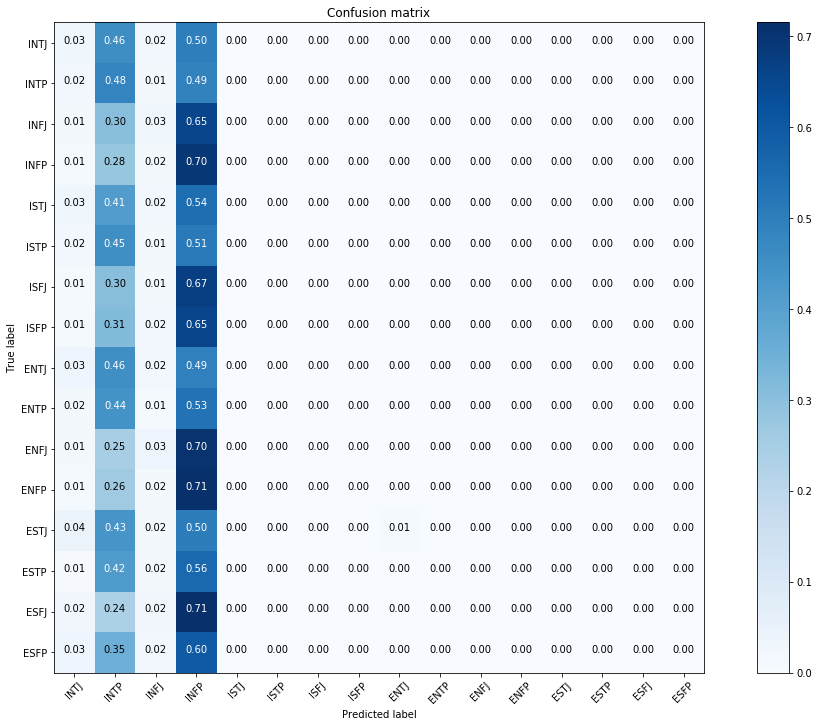

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

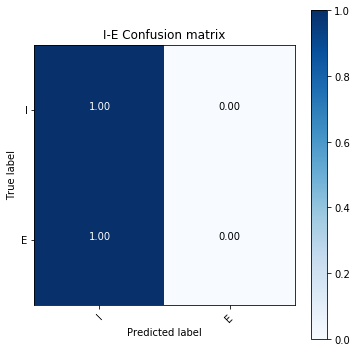

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

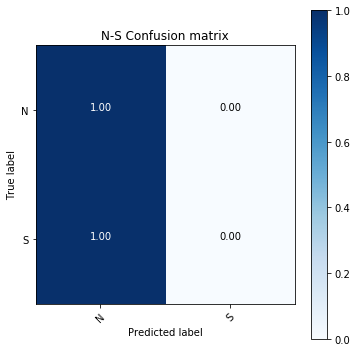

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

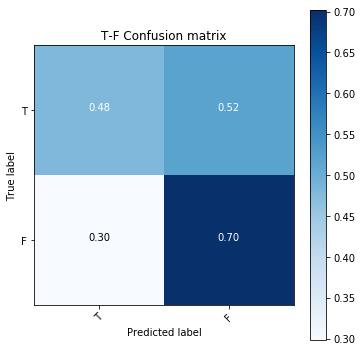

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

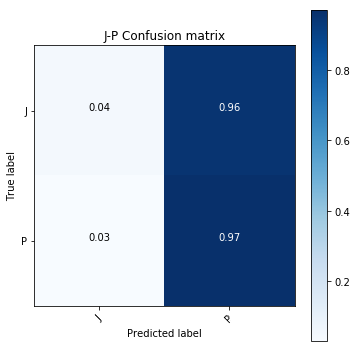

In [47]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=type_labels)
matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(15,10))
plot_confusion_matrix(matrix, classes=type_labels, normalize=True,
                      title='Confusion matrix')
plt.show()

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
                      title='I-E Confusion matrix')
plt.show()

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
                      title='N-S Confusion matrix')
plt.show()

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
                      title='T-F Confusion matrix')
plt.show()

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
                      title='J-P Confusion matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()